<img src="https://account.cin.ufpe.br/img/logo-horizontal.1c557418.png" width="300">

### <span style="color:red">Disciplina: IN1098 - 2025.2</span>
### <span style="color:red">Tema: DIFFERENTIAL PRIVACY</span>
### <span style="color:red">Alunos: Roberto De Medeiros e Arthur Fernandes</span>

#### Introdução
- O conceito de privacidade diferencial foi formalizado por Cynthia Dwork, Frank McSherry, Kobbi Nissim e Adam Smith em 2006.
- A motivação era resolver um problema clássico: como publicar estatísticas úteis de bases de dados (como censos ou registros médicos) sem comprometer a privacidade de indivíduos. Antes disso, métodos como anonimização simples (remover nomes, endereços) mostraram-se frágeis, pois era possível reidentificar pessoas cruzando informações com outras bases.
- O mecanismo funciona adicionando ruído estatístico (aleatoriedade controlada) às respostas de consultas em bancos de dados. Assim, o resultado de uma análise é praticamente o mesmo, independentemente de um indivíduo estar ou não presente nos dados. Isso garante que nenhuma pessoa possa ser identificada com confiança a partir das estatísticas publicadas.

<img src="https://www.nist.gov/sites/default/files/images/2021/07/08/DP%20Blog%20Figure%201.png" width="444">
Fig 1. Abordagens estáticas e dinâmicas para análise de programas para comprovação automática de Differential Privacy. Extraído do original em [4].

#### Justificativa / Vantagens
- Proteção contra reidentificação: Mesmo dados “anônimos” podem ser cruzados com outras fontes e revelar identidades.
- Garantia matemática: definição formal de privacidade baseada em probabilidade, que limita o quanto se pode aprender sobre um indivíduo.
- Equilíbrio entre utilidade e privacidade: extrair padrões coletivos sem expor detalhes pessoais.
- Exemplo: Imagine uma pesquisa sobre hábitos alimentares
- - Sem privacidade diferencial: se alguém descobre que você participou, pode inferir suas preferências.
- - Com privacidade diferencial: o sistema adiciona “ruído” às respostas, de modo que não se sabe se uma resposta específica veio de você ou de outra pessoa, mas ainda é possível ver tendências gerais (ex.: “70% preferem frutas no café da manhã”).

#### Casos de uso na prática
- Censo dos EUA (2020): O U.S. Census Bureau aplicou differential privacy para proteger dados demográficos divulgados publicamente. [5]
- Apple: Implementa differential privacy em iPhones para coletar estatísticas de uso (como emojis mais usados) sem comprometer a privacidade dos usuários. [6]
- Google: Utiliza differential privacy em ferramentas como Chrome e em pesquisas agregadas para melhorar produtos sem expor dados individuais. [7]
- Saúde: Hospitais podem compartilhar estatísticas sobre doenças sem revelar informações sensíveis de pacientes. [8]

#### Referências
- [1] Dwork, C.; McSherry, F.; Nissim, K.; Smith, A. Calibrating Noise to Sensitivity in Private Data Analysis. In: Proceedings of the 3rd Theory of Cryptography Conference (TCC 2006), Lecture Notes in Computer Science, vol. 3876, pp. 265–284. Springer. 2006.
- [2] Dwork, C. & Roth, A. The Algorithmic Foundations of Differential Privacy. Foundations and Trends in Theoretical Computer Science, 9(3–4), 211–407. 2014.
- [3] Alzoubi, Y. I. & Mishra, A. Differential privacy and artificial intelligence: potentials, challenges, and future avenues. EURASIP Journal on Information Security, 2025(18). 2025.
- [4] Abuah, Chike. Automatic Proofs of Differential Privacy.  Cybersecurity Insights a NIST blog. Publicado em 22 de julho de 2021. Disponível em https://www.nist.gov/blogs/cybersecurity-insights/automatic-proofs-differential-privacy. Acesso em 01 de dez de 2025.
- [5] Abowd, J. M. The U.S. Census Bureau Adopts Differential Privacy. Proceedings of the 24th ACM SIGKDD International Conference on Knowledge Discovery & Data Mining, pp. 2867–2867. 2018.
- [6] Apple. Differential Privacy Overview. Apple Machine Learning Journal, Vol. 1. 2017.
- [7] Erlingsson, Ú.; Pihur, V.; Korolova, A. RAPPOR: Randomized Aggregatable Privacy-Preserving Ordinal Response. Proceedings of the 2014 ACM SIGSAC Conference on Computer and Communications Security, pp. 1054–1067. 2014.
- [8] Dankar, F. K.; El Emam, K. The application of differential privacy to health data. Proceedings of the 2012 ACM Workshop on Privacy in the Electronic Society (WPES ’12), pp. 123–132. 2012.

Device: cpu
Epoch 1: train_loss=1.8445, train_acc=31.79%, test_loss=1.4340, test_acc=47.00%
Epoch 2: train_loss=1.4539, train_acc=46.94%, test_loss=1.1975, test_acc=57.14%
Epoch 3: train_loss=1.2572, train_acc=54.85%, test_loss=1.0215, test_acc=63.13%
Baseline salvo em checkpoints/baseline.pth


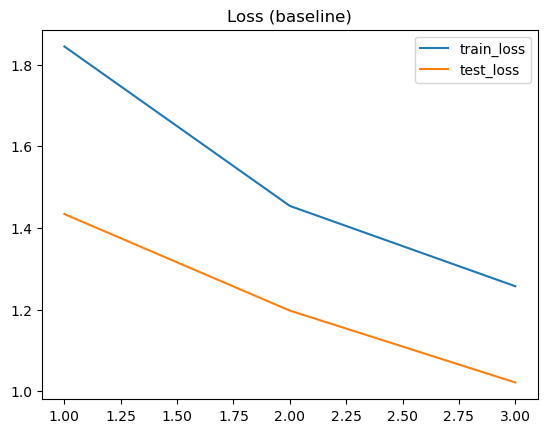

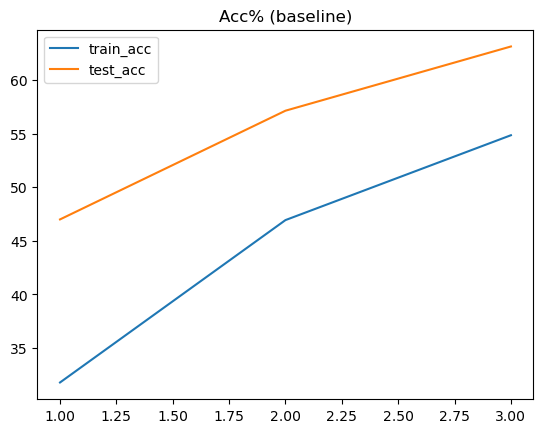

In [2]:
# -----------------------
# PARTE A: Baseline (rodar primeiro)
# -----------------------
# Copie/cole esta célula inteira e execute.
import os
import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

# Reprodutibilidade
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# Transforms (CIFAR-10)
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465),
                         (0.2470, 0.2435, 0.2616))
])
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465),
                         (0.2470, 0.2435, 0.2616))
])

# Datasets / DataLoaders (ajuste batch se precisar)
train_dataset = torchvision.datasets.CIFAR10(root="./data", train=True, download=True, transform=transform_train)
test_dataset  = torchvision.datasets.CIFAR10(root="./data", train=False, download=True, transform=transform_test)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=2)
test_loader  = DataLoader(test_dataset,  batch_size=256, shuffle=False, num_workers=2)

# Modelo robusto: calcula o tamanho flatten automaticamente
class SimpleConvNet(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        # vamos determinar dinamicamente o tamanho do flatten
        with torch.no_grad():
            dummy = torch.zeros(1, 3, 32, 32)
            out = self._forward_features(dummy)
            flat_dim = out.view(1, -1).size(1)
        self.fc1 = nn.Linear(flat_dim, 256)
        self.dropout = nn.Dropout(0.3)
        self.fc2 = nn.Linear(256, num_classes)

    def _forward_features(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        return x

    def forward(self, x):
        x = self._forward_features(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        return self.fc2(x)

# Funções de treino / avaliação
def train_one_epoch(model, optimizer, loader, criterion):
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)
        _, preds = outputs.max(1)
        total += labels.size(0)
        correct += preds.eq(labels).sum().item()
    return running_loss / total, correct / total

def evaluate(model, loader, criterion):
    model.eval()
    running_loss, correct, total = 0.0, 0, 0
    all_preds, all_labels = [], []
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * images.size(0)
            _, preds = outputs.max(1)
            total += labels.size(0)
            correct += preds.eq(labels).sum().item()
            all_preds.append(preds.cpu().numpy())
            all_labels.append(labels.cpu().numpy())
    return running_loss / total, correct / total, np.concatenate(all_preds), np.concatenate(all_labels)

# Treinamento baseline (rápido por padrão)
model = SimpleConvNet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)

EPOCHS = 3  # ajuste aqui
train_losses, train_accs, test_losses, test_accs = [], [], [], []

for epoch in range(1, EPOCHS+1):
    tr_loss, tr_acc = train_one_epoch(model, optimizer, train_loader, criterion)
    te_loss, te_acc, _, _ = evaluate(model, test_loader, criterion)
    train_losses.append(tr_loss); train_accs.append(tr_acc)
    test_losses.append(te_loss); test_accs.append(te_acc)
    print(f"Epoch {epoch}: train_loss={tr_loss:.4f}, train_acc={100*tr_acc:.2f}%, test_loss={te_loss:.4f}, test_acc={100*te_acc:.2f}%")

# Salva checkpoint baseline (apenas pesos)
os.makedirs("checkpoints", exist_ok=True)
baseline_path = "checkpoints/baseline.pth"
torch.save(model.state_dict(), baseline_path)
print("Baseline salvo em", baseline_path)

# Plots simples (opcional)
plt.figure(); plt.plot(range(1,len(train_losses)+1), train_losses, label="train_loss"); plt.plot(range(1,len(test_losses)+1), test_losses, label="test_loss"); plt.legend(); plt.title("Loss (baseline)"); plt.show()
plt.figure(); plt.plot(range(1,len(train_accs)+1), [100*x for x in train_accs], label="train_acc"); plt.plot(range(1,len(test_accs)+1), [100*x for x in test_accs], label="test_acc"); plt.legend(); plt.title("Acc% (baseline)"); plt.show()


Device: cpu
Opacus importado: 1.3.0
Usando PrivacyEngine.make_private_with_epsilon(...)


C:\Users\Public\Anaconda3\Lib\site-packages\opacus\privacy_engine.py:142: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
C:\Users\Public\Anaconda3\Lib\site-packages\opacus\accountants\analysis\rdp.py:332: UserWarning: Optimal order is the largest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(
C:\Users\Public\Anaconda3\Lib\site-packages\opacus\accountants\analysis\prv\prvs.py:50: RuntimeWarning: invalid value encountered in log
  z = np.log((np.exp(t) + q - 1) / q)


Privacy engine ativo. Iniciando treino DP (epocas: 3 )


C:\Users\Public\Anaconda3\Lib\site-packages\torch\nn\modules\module.py:1866: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


Epoch 1: train_loss=2.1017, train_acc=22.87%, test_loss=1.9088, test_acc=31.97%, epsilon=2.43
Epoch 2: train_loss=1.9665, train_acc=29.83%, test_loss=1.7868, test_acc=36.98%, epsilon=2.77
Epoch 3: train_loss=1.9173, train_acc=32.47%, test_loss=1.7244, test_acc=39.15%, epsilon=3.00
Modelo DP salvo em checkpoints/dp_model.pth


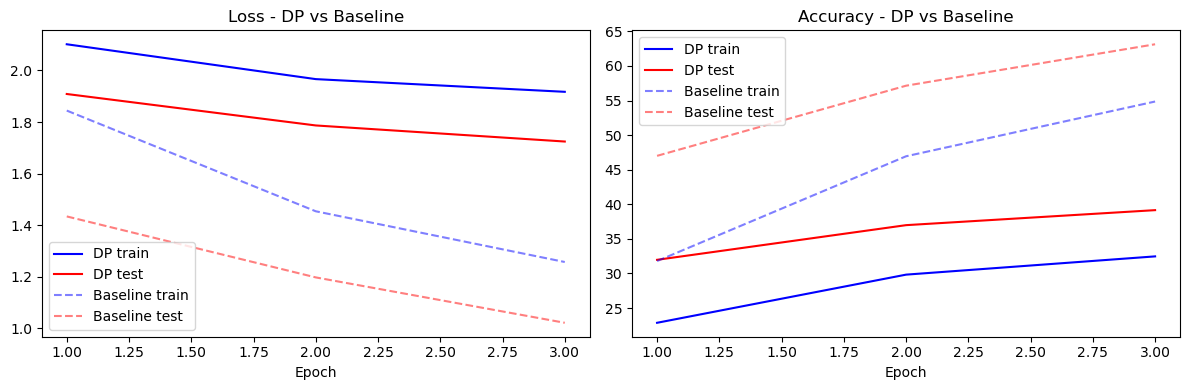


=== RELATÓRIO FINAL ===
Baseline - Melhor acurácia: 63.13%
DP - Melhor acurácia: 39.15%
Privacidade final: ε = 3.00, δ = 1e-05


In [3]:
# -----------------------
# PARTE B: Differential Privacy (rodar separadamente)
# -----------------------
import importlib
import sys
import os

print("Device:", device)

# Opcional: carregar pesos baseline (se quiser iniciar o modelo DP a partir do baseline)
load_baseline = False  # <--- coloque True se quiser usar pesos do baseline.pth
baseline_path = "checkpoints/baseline.pth"

# Criar novo modelo para DP
model_dp = SimpleConvNet().to(device)
if load_baseline and os.path.exists(baseline_path):
    sd = torch.load(baseline_path, map_location=device)
    model_dp.load_state_dict(sd)
    print("Pesos baseline carregados para inicializar modelo DP.")

optimizer_dp = optim.SGD(model_dp.parameters(), lr=0.01, momentum=0.9)
criterion_dp = nn.CrossEntropyLoss()

# Verifica Opacus
try:
    import opacus
    from opacus import PrivacyEngine
    print("Opacus importado:", opacus.__version__)
except Exception as e:
    print("Opacus não está disponível ou falhou ao importar:", repr(e))
    print("Para usar DP com Opacus instale uma versão compatível, por exemplo:")
    print("  pip install opacus==1.3.0")
    print("Também garanta compatibilidade torch/torchvision (ex.: torch 2.1.0 + torchvision 0.16.0).")
    raise RuntimeError("Opacus necessário para executar a Parte B (DP).")

# Configurações DP
batch_size_dp = 64
# IMPORTANTE: Desativar multiprocessing para evitar problemas de serialização
train_loader_dp = DataLoader(train_dataset, batch_size=batch_size_dp, shuffle=True, num_workers=0)

# Tentaremos chamar APIs diferentes do PrivacyEngine dependendo da versão do Opacus
privacy_engine = PrivacyEngine()

# Parâmetros de exemplo (ajuste conforme seu interesse)
noise_multiplier = 1.1
max_grad_norm = 1.0
target_epsilon = 3.0
target_delta = 1e-5
epochs_dp = 3

# Tenta usar make_private_with_epsilon -> make_private -> attach com sample_rate, na ordem
success = False
try:
    # API: make_private_with_epsilon (aponta versão mais nova)
    if hasattr(privacy_engine, "make_private_with_epsilon"):
        print("Usando PrivacyEngine.make_private_with_epsilon(...)")
        model_dp, optimizer_dp, train_loader_dp = privacy_engine.make_private_with_epsilon(
            module=model_dp,
            optimizer=optimizer_dp,
            data_loader=train_loader_dp,
            target_epsilon=target_epsilon,
            target_delta=target_delta,
            epochs=epochs_dp,
            max_grad_norm=max_grad_norm,
        )
        success = True
except Exception as e:
    print("make_private_with_epsilon falhou:", repr(e))

if not success:
    try:
        # API: make_private (mais comum)
        if hasattr(privacy_engine, "make_private"):
            print("Tentando PrivacyEngine.make_private(...)")
            model_dp, optimizer_dp, train_loader_dp = privacy_engine.make_private(
                module=model_dp,
                optimizer=optimizer_dp,
                data_loader=train_loader_dp,
                noise_multiplier=noise_multiplier,
                max_grad_norm=max_grad_norm,
            )
            success = True
    except Exception as e:
        print("make_private falhou:", repr(e))

if not success:
    try:
        # API alternativa: attach (antigas versões)
        print("Tentando PrivacyEngine.attach(...)")
        # Para attach algumas versões exigem sample_rate e sample_size - calculamos:
        sample_rate = batch_size_dp / float(len(train_dataset))
        privacy_engine = PrivacyEngine(
            model_dp,
            sample_rate=sample_rate,
            alphas=[10, 100],
            noise_multiplier=noise_multiplier,
            max_grad_norm=max_grad_norm,
        )
        privacy_engine.attach(optimizer_dp)
        success = True
    except Exception as e:
        print("attach falhou:", repr(e))

if not success:
    print("\nNenhuma API do Opacus funcionou automaticamente neste ambiente.")
    print("Soluções:")
    print("  1) Instale opacus==1.3.0 e versões compatíveis de torch/torchvision (recomendado):")
    print("       pip install opacus==1.3.0 torch==2.1.0 torchvision==0.16.0 --index-url https://download.pytorch.org/whl/cpu")
    print("  2) Se preferir, posso gerar uma versão 'fallback' que aplica ruído aos gradientes manualmente (aproximado).")
    raise RuntimeError("Opacus API incompatível - Parte DP abortada sem afetar baseline.")

# Se chegamos até aqui, Opacus foi ligado e train_loader_dp é o loader que o engine retornou
print("Privacy engine ativo. Iniciando treino DP (epocas:", epochs_dp, ")")

# Função de treino adaptada para DP
def train_one_epoch_dp(model, optimizer, loader, criterion):
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    
    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * images.size(0)
        _, preds = outputs.max(1)
        total += labels.size(0)
        correct += preds.eq(labels).sum().item()
    
    return running_loss / total, correct / total

# Loop de treino DP (similar ao baseline)
train_losses_dp = []
train_accs_dp = []
test_losses_dp = []
test_accs_dp = []

for epoch in range(1, epochs_dp + 1):
    tr_loss, tr_acc = train_one_epoch_dp(model_dp, optimizer_dp, train_loader_dp, criterion_dp)
    te_loss, te_acc, _, _ = evaluate(model_dp, test_loader, criterion_dp)
    
    train_losses_dp.append(tr_loss)
    train_accs_dp.append(tr_acc)
    test_losses_dp.append(te_loss)
    test_accs_dp.append(te_acc)
    
    # Obter epsilon atual
    if hasattr(privacy_engine, 'get_epsilon'):
        epsilon = privacy_engine.get_epsilon(target_delta)
    else:
        epsilon = target_epsilon  # fallback
    
    print(f"Epoch {epoch}: train_loss={tr_loss:.4f}, train_acc={100*tr_acc:.2f}%, "
          f"test_loss={te_loss:.4f}, test_acc={100*te_acc:.2f}%, epsilon={epsilon:.2f}")

# Salvar modelo DP
dp_path = "checkpoints/dp_model.pth"
torch.save(model_dp.state_dict(), dp_path)
print(f"Modelo DP salvo em {dp_path}")

# Plots comparativos
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(range(1, len(train_losses_dp)+1), train_losses_dp, 'b-', label='DP train')
plt.plot(range(1, len(test_losses_dp)+1), test_losses_dp, 'r-', label='DP test')
if len(train_losses) > 0:  # Se baseline foi treinado
    plt.plot(range(1, len(train_losses)+1), train_losses, 'b--', alpha=0.5, label='Baseline train')
    plt.plot(range(1, len(test_losses)+1), test_losses, 'r--', alpha=0.5, label='Baseline test')
plt.legend()
plt.title("Loss - DP vs Baseline")
plt.xlabel("Epoch")

plt.subplot(1, 2, 2)
plt.plot(range(1, len(train_accs_dp)+1), [100*x for x in train_accs_dp], 'b-', label='DP train')
plt.plot(range(1, len(test_accs_dp)+1), [100*x for x in test_accs_dp], 'r-', label='DP test')
if len(train_accs) > 0:  # Se baseline foi treinado
    plt.plot(range(1, len(train_accs)+1), [100*x for x in train_accs], 'b--', alpha=0.5, label='Baseline train')
    plt.plot(range(1, len(test_accs)+1), [100*x for x in test_accs], 'r--', alpha=0.5, label='Baseline test')
plt.legend()
plt.title("Accuracy - DP vs Baseline")
plt.xlabel("Epoch")

plt.tight_layout()
plt.show()

# Relatório final
print("\n=== RELATÓRIO FINAL ===")
if len(test_accs) > 0:
    print(f"Baseline - Melhor acurácia: {100*max(test_accs):.2f}%")
print(f"DP - Melhor acurácia: {100*max(test_accs_dp):.2f}%")

if hasattr(privacy_engine, 'get_epsilon'):
    final_epsilon = privacy_engine.get_epsilon(target_delta)
    print(f"Privacidade final: ε = {final_epsilon:.2f}, δ = {target_delta}")
else:
    print(f"Privacidade alvo: ε = {target_epsilon:.2f}, δ = {target_delta}")